In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
#import data
concrete_data = pd.read_csv('Concrete_Data_Yeh.csv')

#print the first 5 rows of the data
print(concrete_data.head())

   cement   slag  flyash  water  superplasticizer  coarseaggregate  \
0   540.0    0.0     0.0  162.0               2.5           1040.0   
1   540.0    0.0     0.0  162.0               2.5           1055.0   
2   332.5  142.5     0.0  228.0               0.0            932.0   
3   332.5  142.5     0.0  228.0               0.0            932.0   
4   198.6  132.4     0.0  192.0               0.0            978.4   

   fineaggregate  age  csMPa  
0          676.0   28  79.99  
1          676.0   28  61.89  
2          594.0  270  40.27  
3          594.0  365  41.05  
4          825.5  360  44.30  


In [3]:
#look at null count and dtype
print(concrete_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB
None


In [4]:
#look at distribution of data
print(concrete_data.describe())

            cement         slag       flyash        water  superplasticizer  \
count  1030.000000  1030.000000  1030.000000  1030.000000       1030.000000   
mean    281.167864    73.895825    54.188350   181.567282          6.204660   
std     104.506364    86.279342    63.997004    21.354219          5.973841   
min     102.000000     0.000000     0.000000   121.800000          0.000000   
25%     192.375000     0.000000     0.000000   164.900000          0.000000   
50%     272.900000    22.000000     0.000000   185.000000          6.400000   
75%     350.000000   142.950000   118.300000   192.000000         10.200000   
max     540.000000   359.400000   200.100000   247.000000         32.200000   

       coarseaggregate  fineaggregate          age        csMPa  
count      1030.000000    1030.000000  1030.000000  1030.000000  
mean        972.918932     773.580485    45.662136    35.817961  
std          77.753954      80.175980    63.169912    16.705742  
min         801.000000  

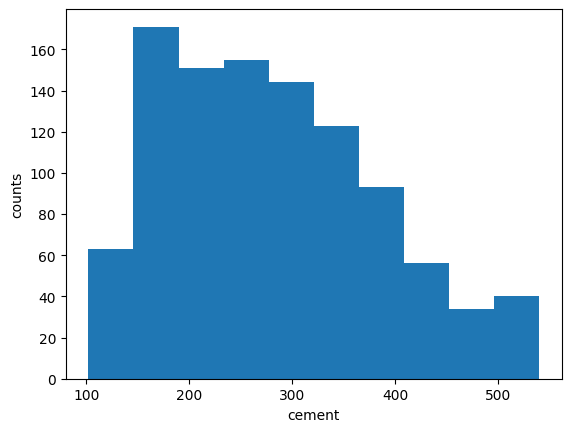

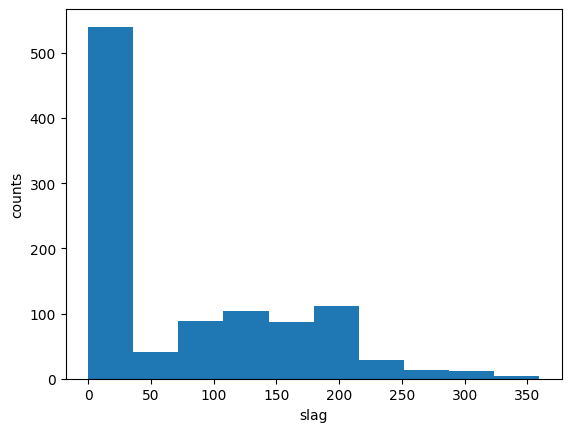

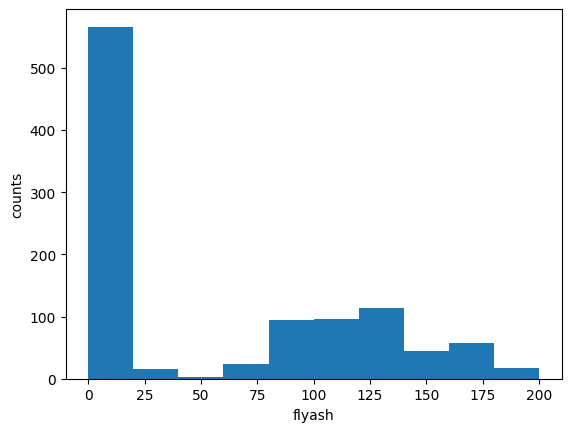

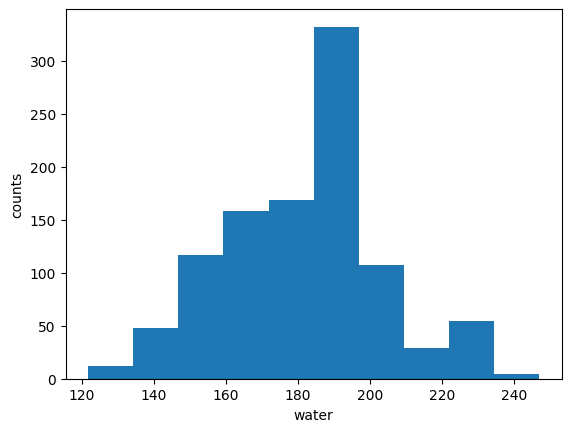

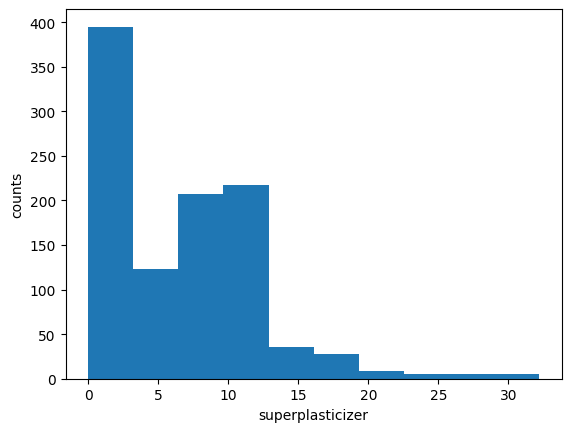

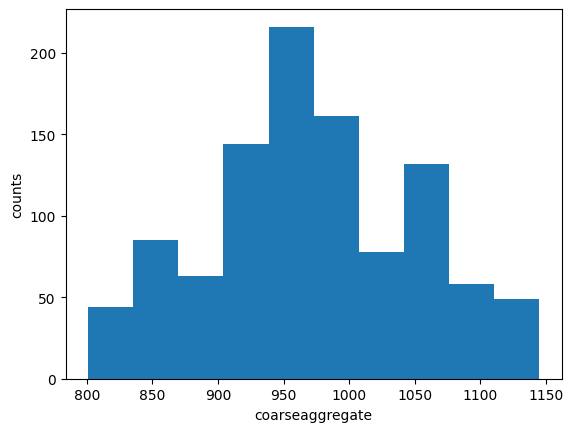

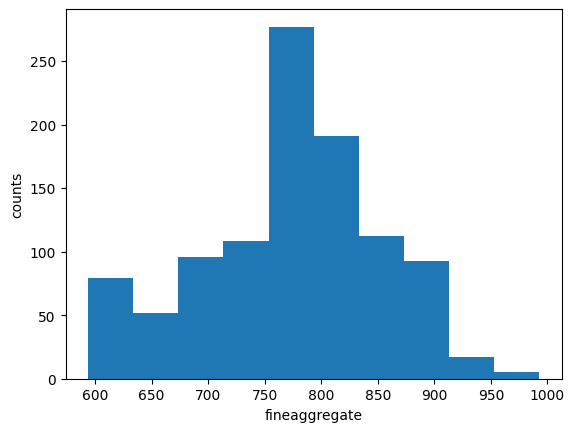

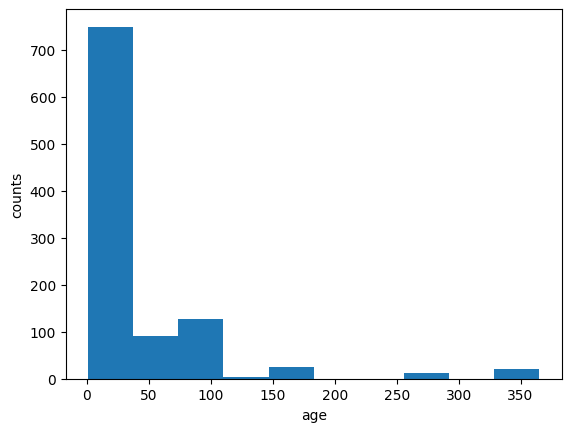

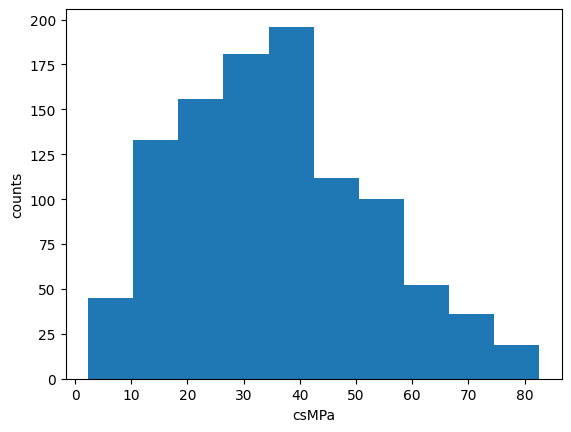

In [5]:
#look at data distribution
for i in concrete_data.columns:
    plt.hist(concrete_data[i])
    plt.xticks()
    plt.xlabel(i)
    plt.ylabel('counts')
    plt.show()

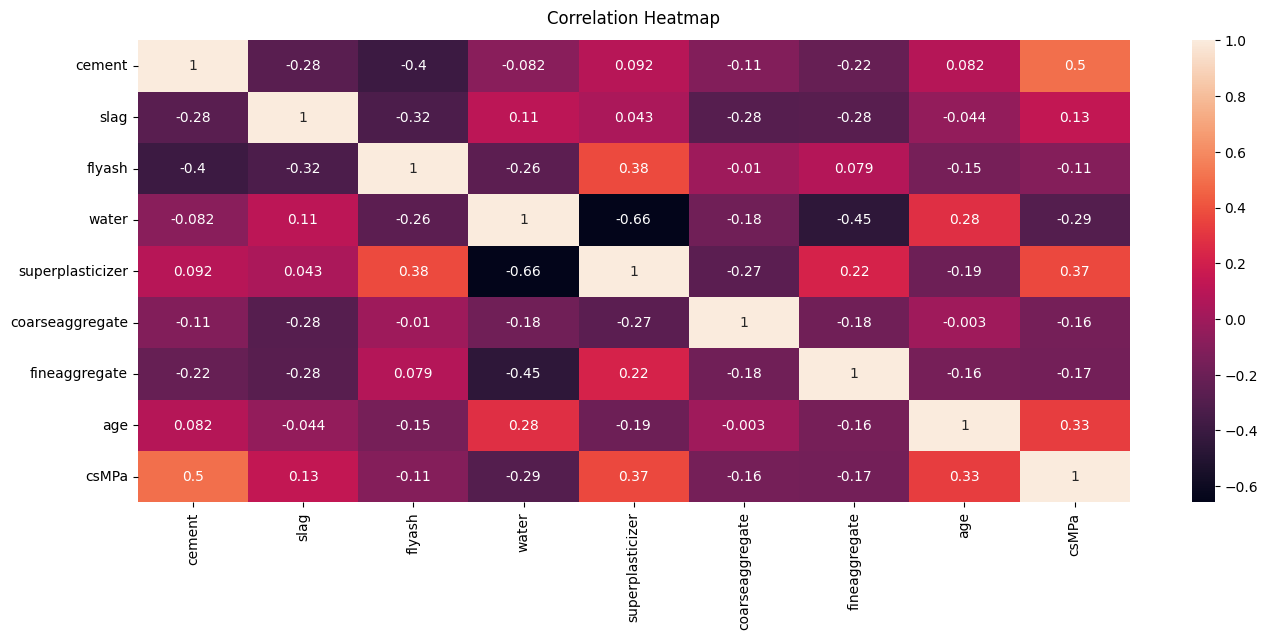

In [6]:
#heat map using Pearson's coefficient
plt.figure(figsize=(16, 6))
sns.heatmap(concrete_data.corr(), annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [7]:
#create bins from compressive strength
bins = pd.qcut(concrete_data['csMPa'], q=4)

#add bins to concrete df
concrete_data['bins']=bins

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


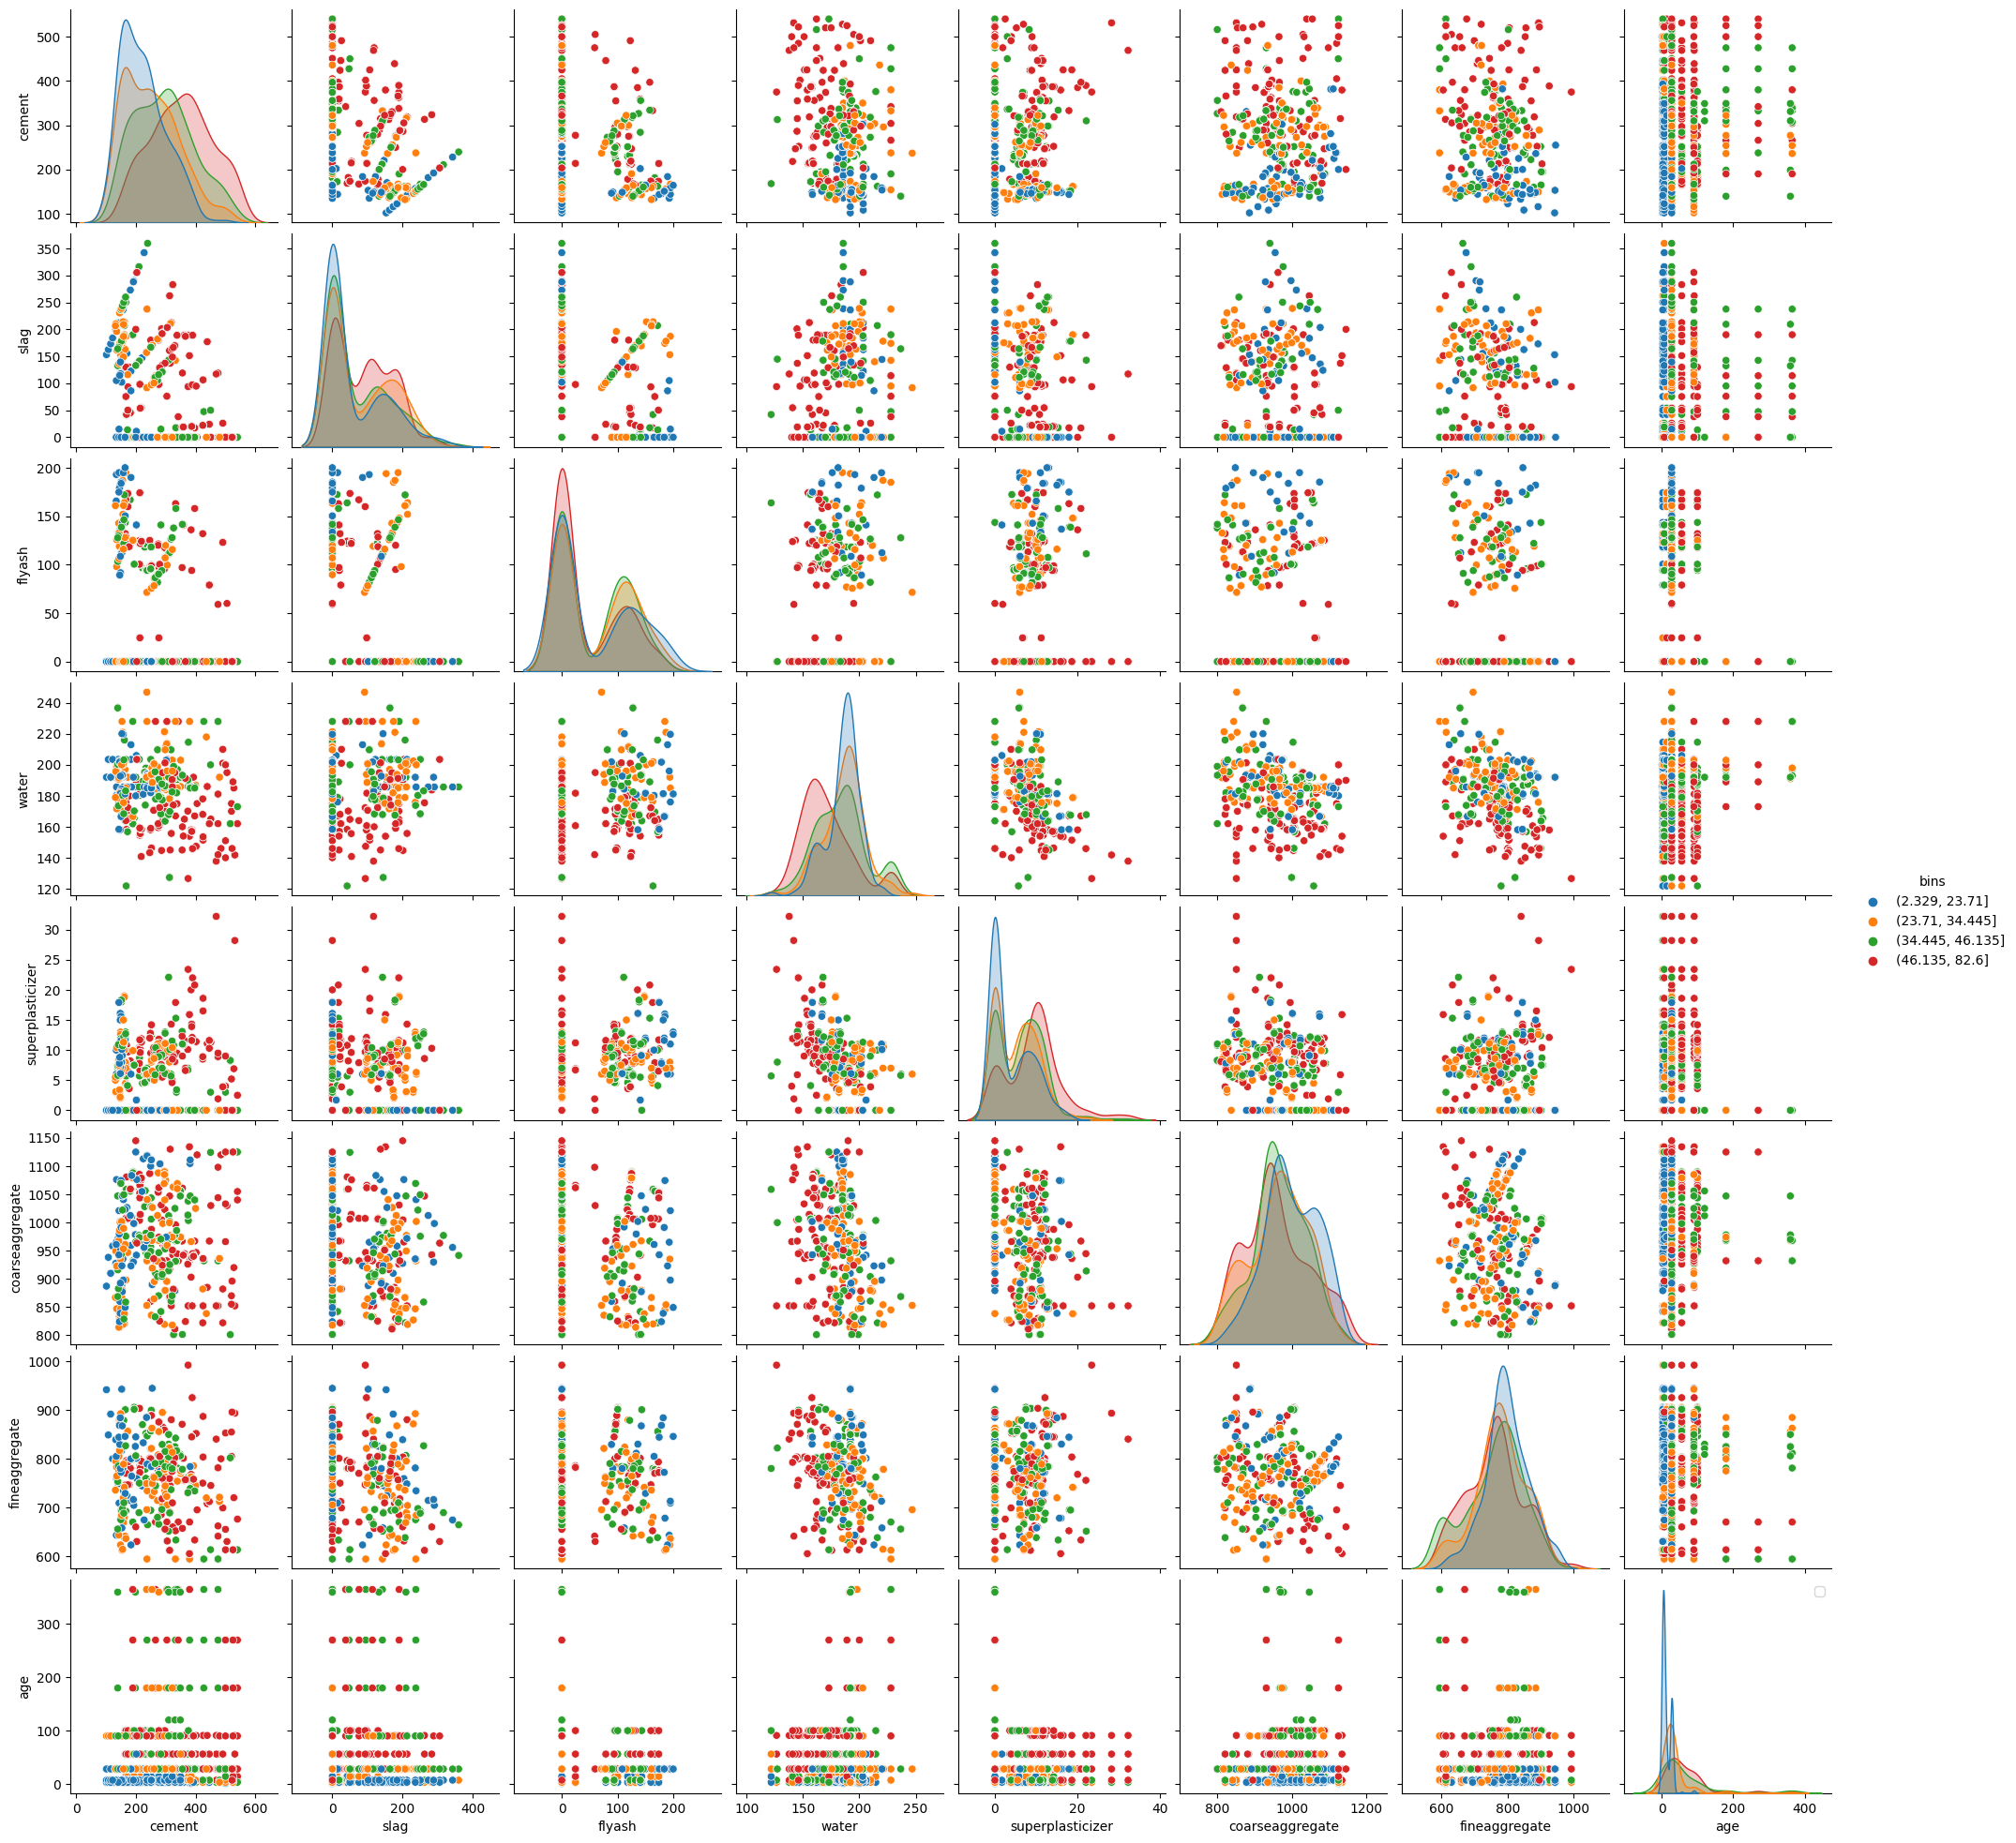

In [9]:
#look at how target is distributed among variables
sns.pairplot(concrete_data.loc[:, (concrete_data.columns != 'csMPa')], hue='bins')
plt.legend()
plt.show()

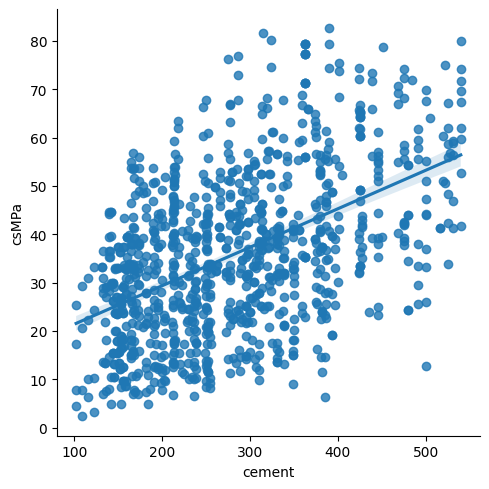

In [10]:
#plot strongest linear correlation
sns.lmplot(x='cement', y='csMPa',data=concrete_data)
plt.show()

In [11]:
#drop bins from concrete data
concrete_data = concrete_data.drop('bins', axis=1)

#copy of variables and target
X = concrete_data.copy()
y = X.pop('csMPa')

In [13]:
#make a copy of features matrix for mutual information analysis
X_mi = X.copy()

#label encoding for categorical variables
for colname in X_mi.select_dtypes("object"):
    X_mi[colname], _ = X_mi[colname].factorize()

#all discrete features have int dtypes
discrete_features = X_mi.dtypes == object

In [14]:


#some continuous variables also have int dtypes
discrete_features[X_mi.columns] = False



In [15]:
#use regression since the target variable is continuous
from sklearn.feature_selection import mutual_info_regression

#define a function to produce mutual information scores
def make_mi_scores(X_mi, y, discrete_features):
    mi_scores = mutual_info_regression(X_mi, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#compute mutual information scores
mi_scores = make_mi_scores(X_mi, y, discrete_features)
mi_scores

age                 0.363266
water               0.361086
cement              0.307685
coarseaggregate     0.257805
superplasticizer    0.214315
fineaggregate       0.208989
slag                0.177105
flyash              0.120655
Name: MI Scores, dtype: float64

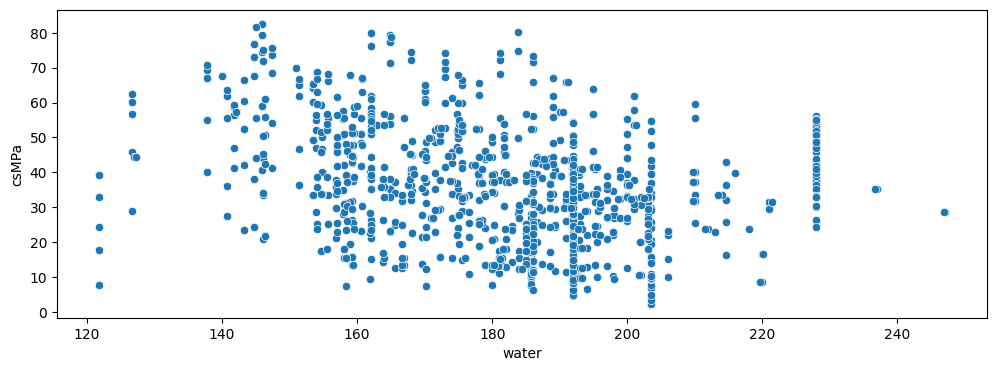

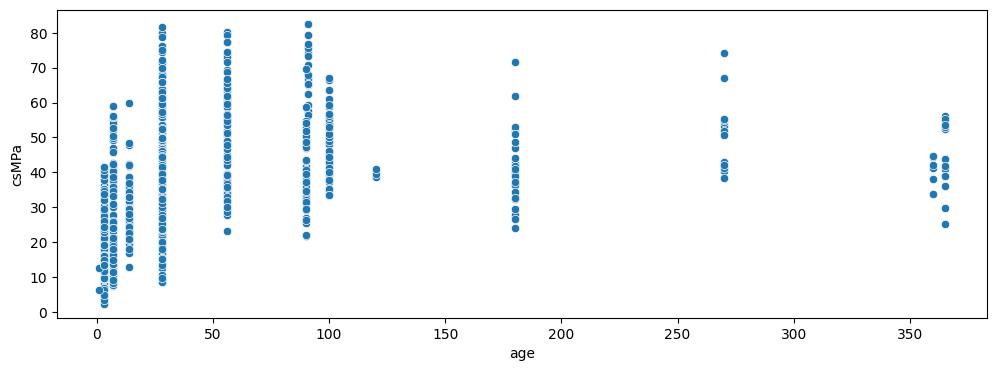

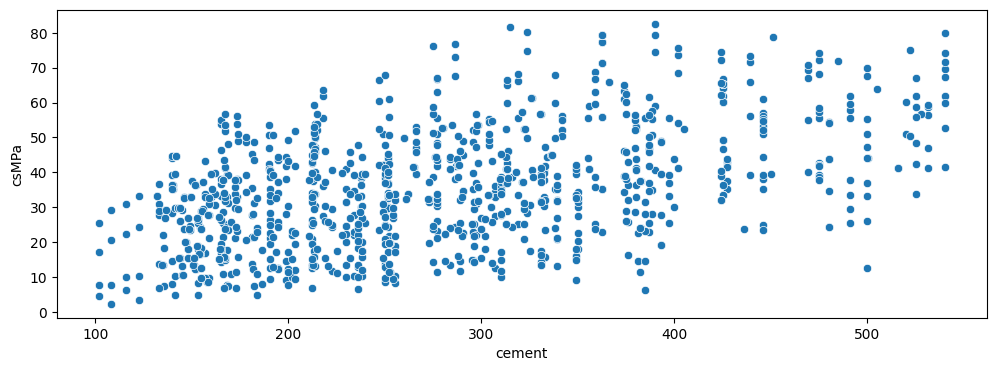

In [16]:
#plot top MI score predictors against target
for i in ['water', 'age', 'cement']:
    fig, ax = plt.subplots(figsize=(12,4))
    sns.scatterplot(x=X_mi[i], y=y, ax=ax)
    plt.show()

In [17]:
#copy features matrix for principal component analysis
X_for_PCA = X.copy()

#standardize
X_for_PCA_scaled = (X_for_PCA - X_for_PCA.mean(axis=0)) / X_for_PCA.std(axis=0)

from sklearn.decomposition import PCA

#create principal components
pca = PCA(len(X.columns))
X_pca = pca.fit_transform(X_for_PCA_scaled)

#convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

In [24]:
pca.components_

array([[ 0.09840137,  0.17726197, -0.39466185,  0.54700395, -0.50594541,
         0.03792808, -0.40192597,  0.29147949],
       [-0.11373709,  0.6860529 , -0.14294751,  0.05325628,  0.2829296 ,
        -0.62994342, -0.01939111, -0.12598089],
       [ 0.81420224, -0.17179437, -0.40822055, -0.21318975,  0.23459653,
        -0.17408781, -0.00456921,  0.10052137],
       [ 0.054297  ,  0.36269932, -0.2267512 , -0.29606003,  0.03727351,
         0.54580513, -0.38528206, -0.52791909],
       [-0.14820612,  0.02093167, -0.54963115, -0.07022191, -0.35461841,
         0.03308317,  0.70123743, -0.22801019],
       [-0.20314214,  0.30488197, -0.1832672 , -0.36597033,  0.19329372,
         0.31455942,  0.09246568,  0.743908  ],
       [-0.22184381, -0.22836331, -0.35246257,  0.52427468,  0.66464314,
         0.22684015,  0.03902583, -0.06936667],
       [ 0.44616267,  0.43738376,  0.38188581,  0.38874117,  0.05174995,
         0.34931986,  0.43336994,  0.01288097]])

In [18]:
X_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     0.678996 -1.457148  2.386464  1.351413 -0.396508 -0.442745 -0.780394   
1     0.686313 -1.578675  2.352880  1.456708 -0.390125 -0.382061 -0.736633   
2     4.153785  0.360166  0.360592 -1.474495 -1.772937  1.570514  0.004422   
3     4.592136  0.170706  0.511764 -2.268422 -2.115838  2.689263 -0.099897   
4     2.362183 -0.275599 -0.276963 -2.626302  0.252528  3.926641 -0.419231   
...        ...       ...       ...       ...       ...       ...       ...   
1025 -0.524533  1.251584 -0.023438 -0.458110 -0.472877 -0.454481 -0.331764   
1026 -0.834248  0.746796  0.412457 -1.812760 -0.553985 -1.417560  0.177896   
1027 -0.184807  1.252531 -1.474559 -0.589810 -0.208032 -0.386981 -0.142131   
1028 -0.283562  1.273667 -0.636633  0.908387  0.587859  0.935362  0.754910   
1029  0.097725  1.257187 -0.245299 -0.788457 -0.464701 -0.844864  0.270808   

           PC8  
0    -0.210926  
1    -0.143536  
2    -0.073657  
3    -0.054285  
4     0.126254  
...        ...  
1025 -0.097961  
1026 -0.018701  
1027 -0.038523  
1028 -0.182989  
1029  0.003463  

[1030 rows x 8 columns]

In [21]:

eigenvalues = pca.explained_variance_
eigenvalues




array([2.28009936, 1.4160748 , 1.34007903, 1.01415887, 0.95150799,
       0.79019547, 0.17784169, 0.03004278])

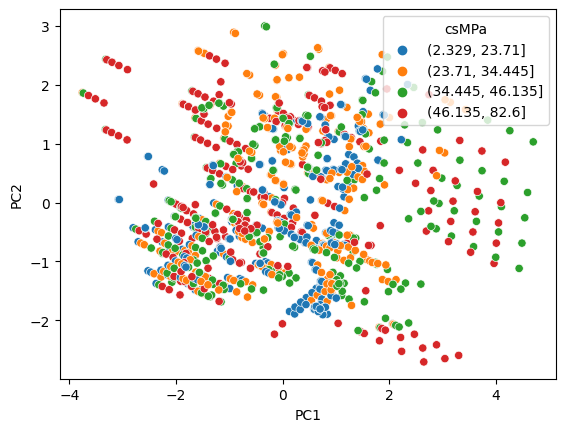

In [22]:
#plot data using principal components
sns.scatterplot(x=X_pca.loc[:,'PC1'],y=X_pca.loc[:,'PC2'], hue=bins)
plt.show()

In [23]:
#determine loadings
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

PC1       PC2       PC3       PC4       PC5       PC6  \
cement            0.098401 -0.113737  0.814202  0.054297 -0.148206 -0.203142   
slag              0.177262  0.686053 -0.171794  0.362699  0.020932  0.304882   
flyash           -0.394662 -0.142948 -0.408221 -0.226751 -0.549631 -0.183267   
water             0.547004  0.053256 -0.213190 -0.296060 -0.070222 -0.365970   
superplasticizer -0.505945  0.282930  0.234597  0.037274 -0.354618  0.193294   
coarseaggregate   0.037928 -0.629943 -0.174088  0.545805  0.033083  0.314559   
fineaggregate    -0.401926 -0.019391 -0.004569 -0.385282  0.701237  0.092466   
age               0.291479 -0.125981  0.100521 -0.527919 -0.228010  0.743908   

                       PC7       PC8  
cement           -0.221844  0.446163  
slag             -0.228363  0.437384  
flyash           -0.352463  0.381886  
water             0.524275  0.388741  
superplasticizer  0.664643  0.051750  
coarseaggregate   0.226840  0.349320  
fineaggregate     0.039026  0.433370  
age              -0.069367  0.012881

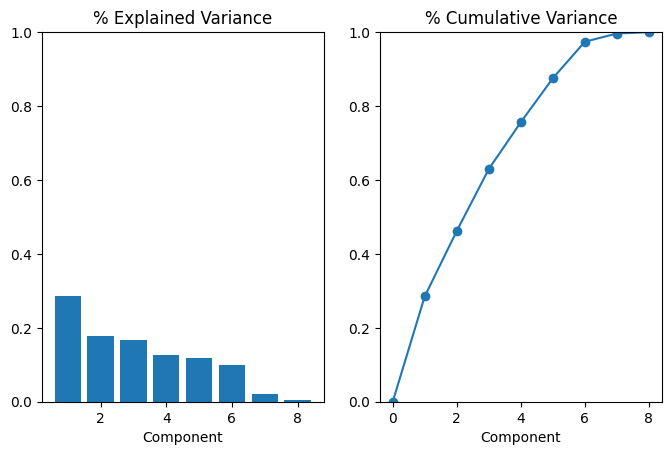

In [25]:
#determine % explained variance and use % cumulative variance for elbow method to determine number of PCs

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

In [27]:
#generate OLS regression results for all features
import statsmodels.api as sm

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     204.3
Date:                Thu, 10 Apr 2025   Prob (F-statistic):          6.29e-206
Time:                        14:11:31   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -23.3312     26.586  

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
#initialize VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
#calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

            feature        VIF
0            cement  15.456717
1              slag   3.329127
2            flyash   4.147833
3             water  82.157569
4  superplasticizer   5.471094
5   coarseaggregate  84.955779
6     fineaggregate  72.790995
7               age   1.699459


In [29]:


#print OLS summary for each feature
for i in X.columns:
    X_sm = sm.add_constant(X[i])
    model = sm.OLS(y,X_sm)
    print(model.fit().summary())



                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     338.7
Date:                Thu, 10 Apr 2025   Prob (F-statistic):           1.32e-65
Time:                        14:12:13   Log-Likelihood:                -4214.6
No. Observations:                1030   AIC:                             8433.
Df Residuals:                    1028   BIC:                             8443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4425      1.297     10.365      0.0

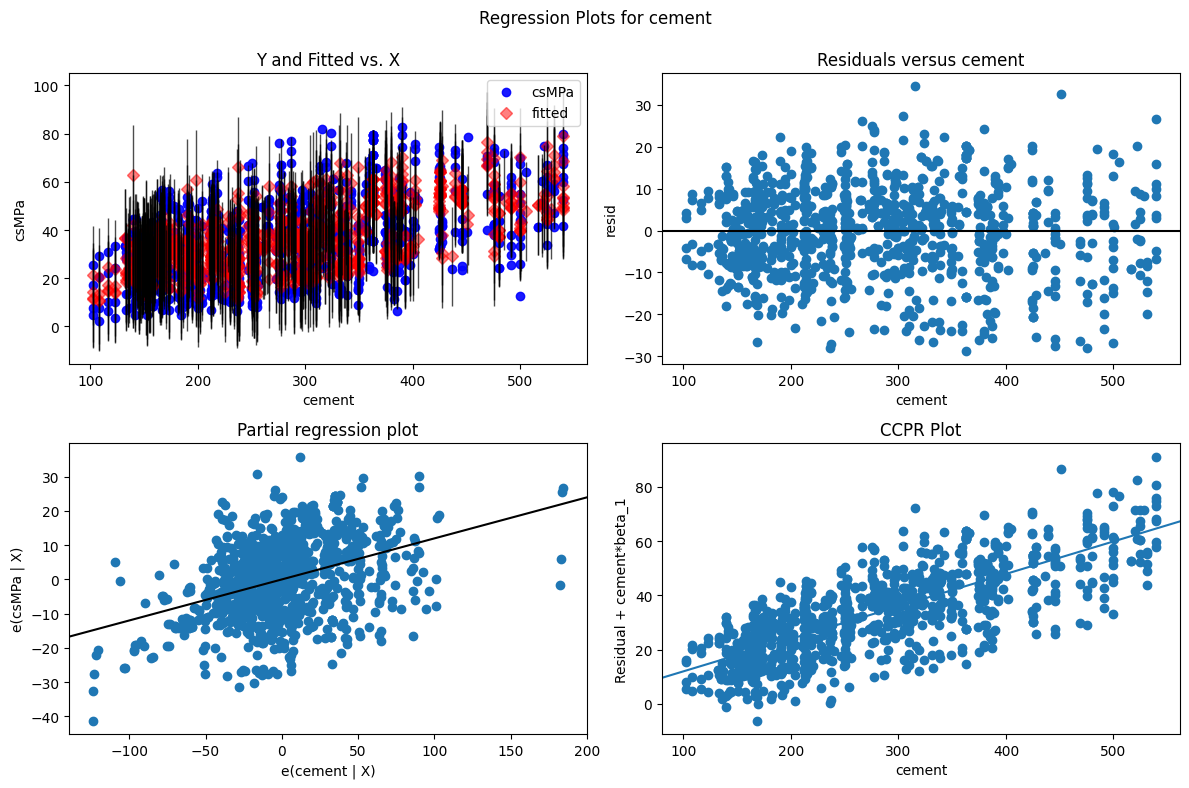

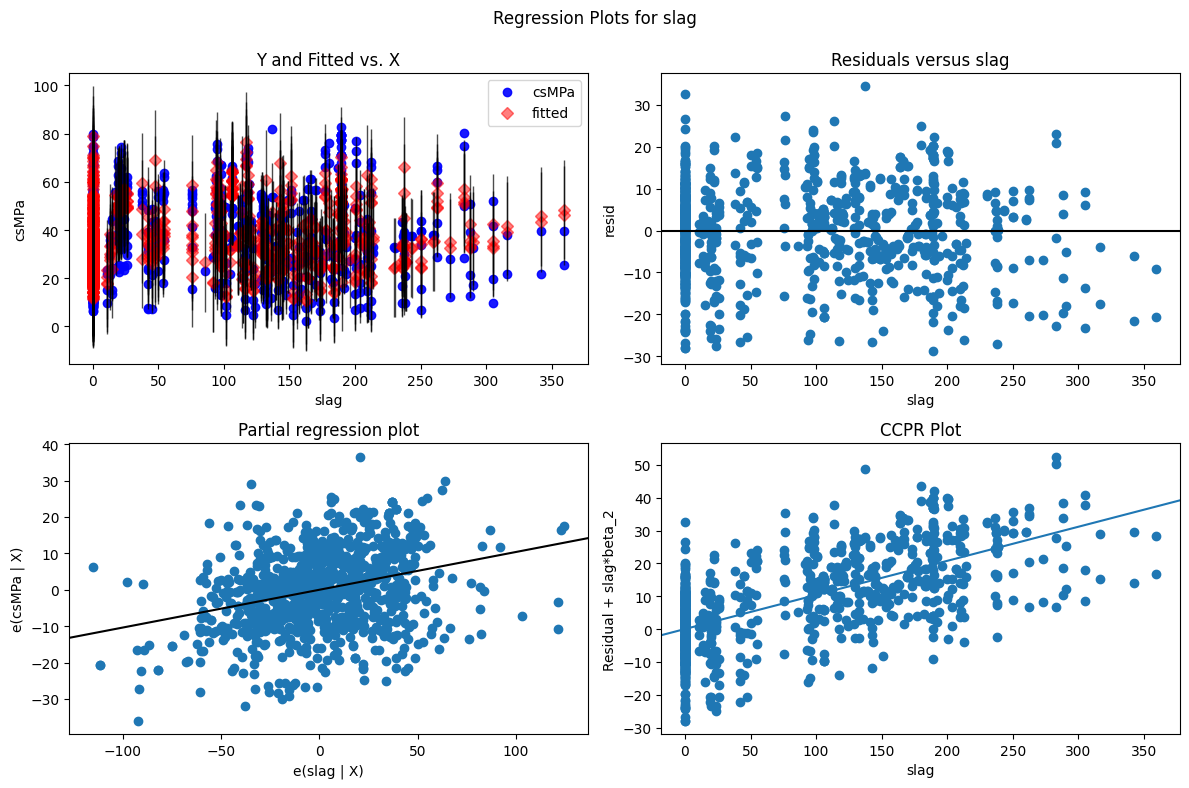

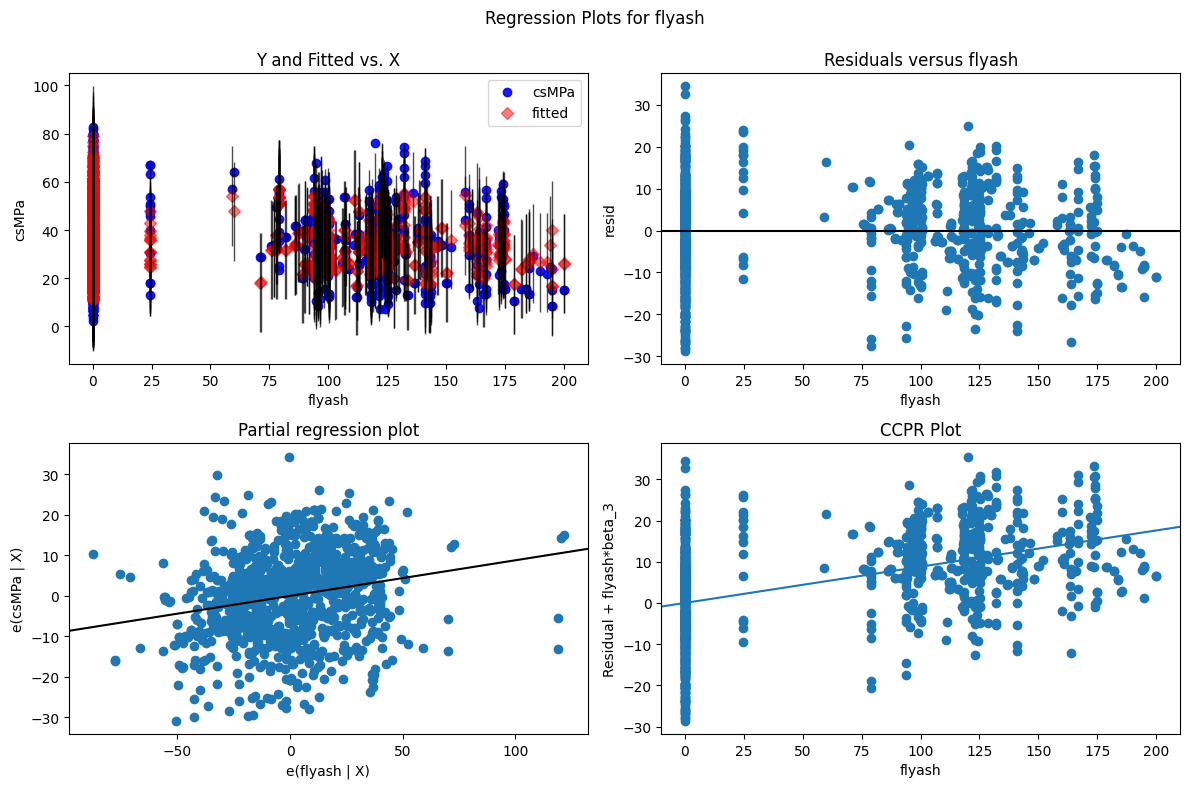

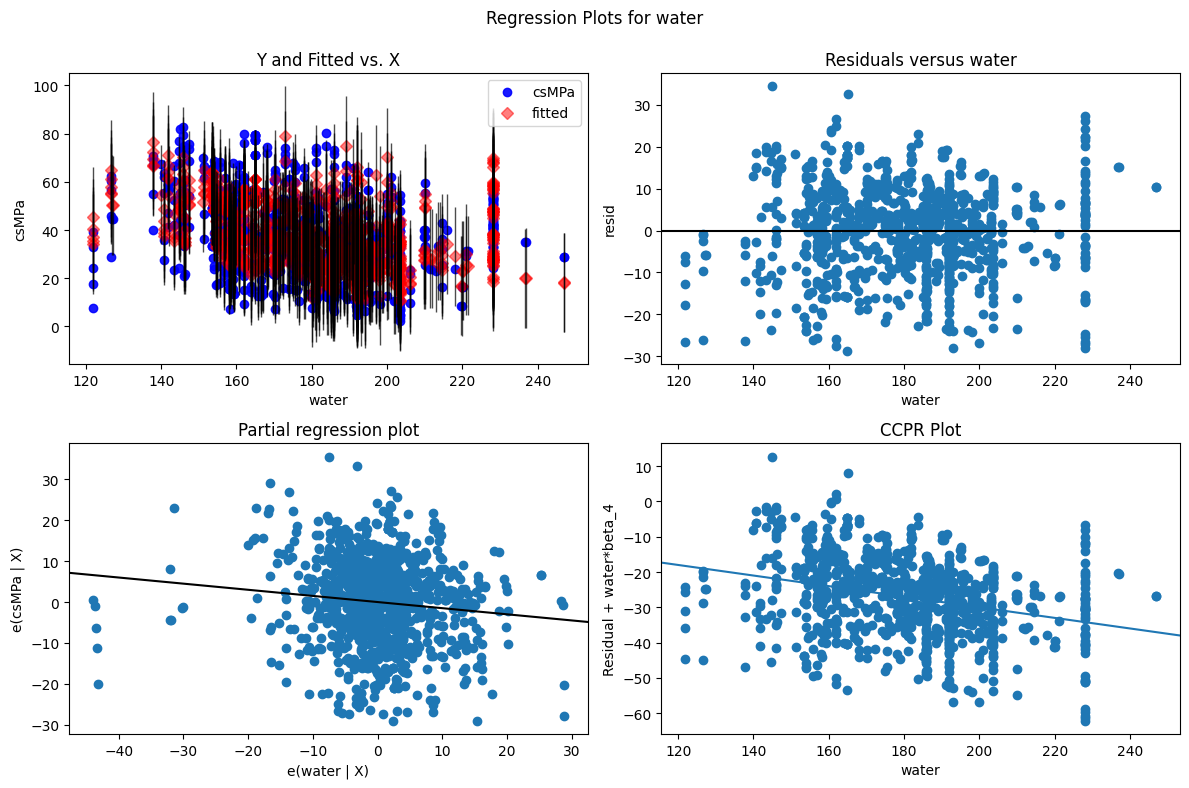

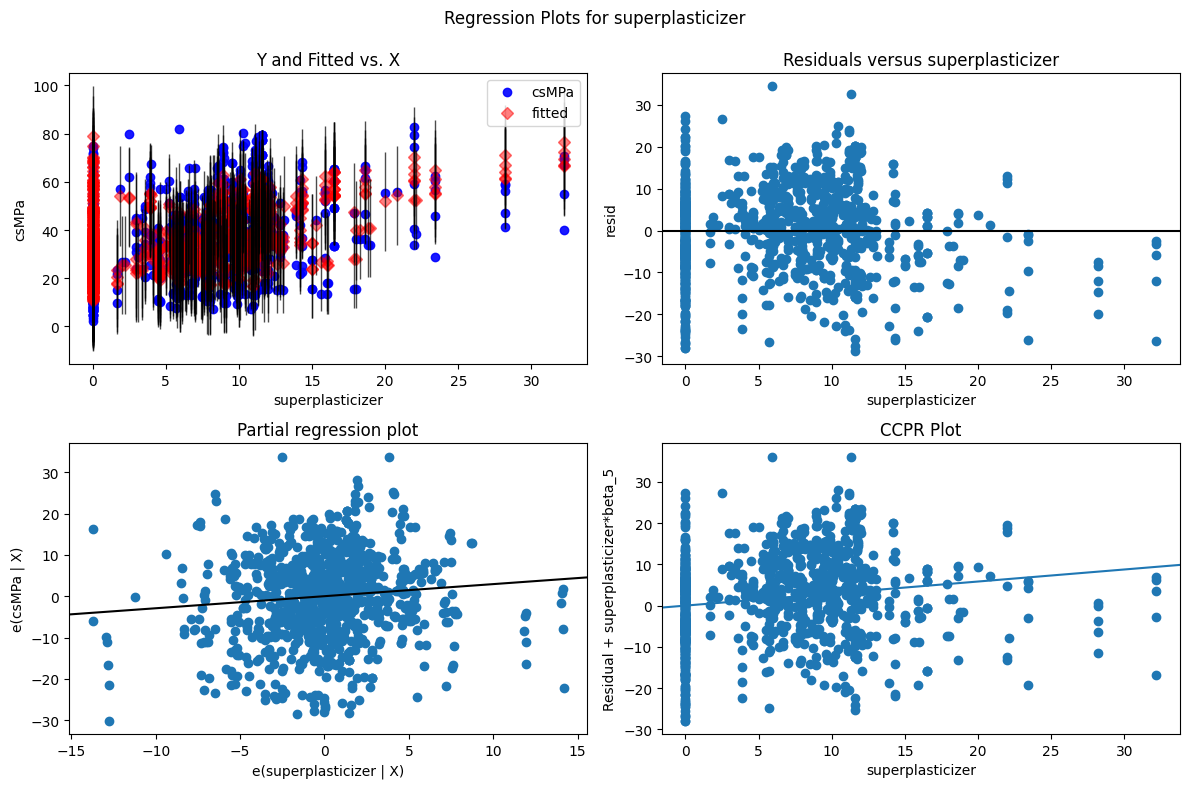

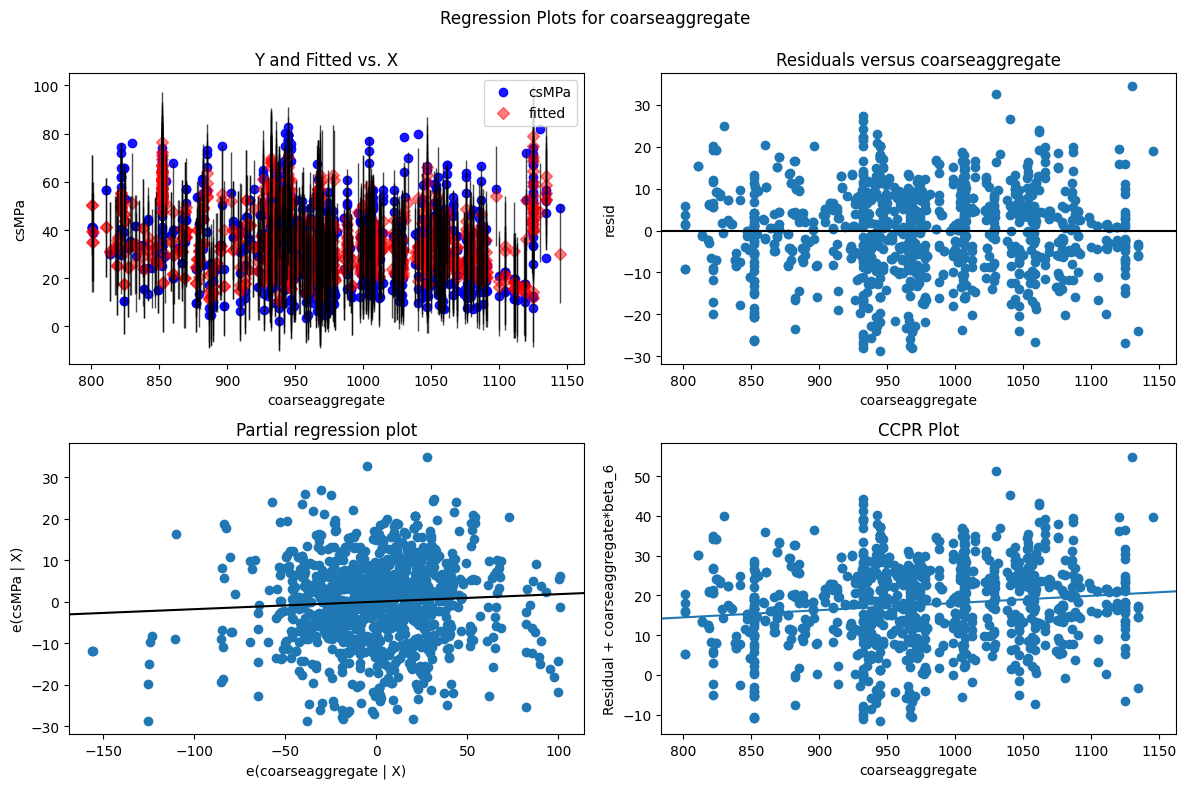

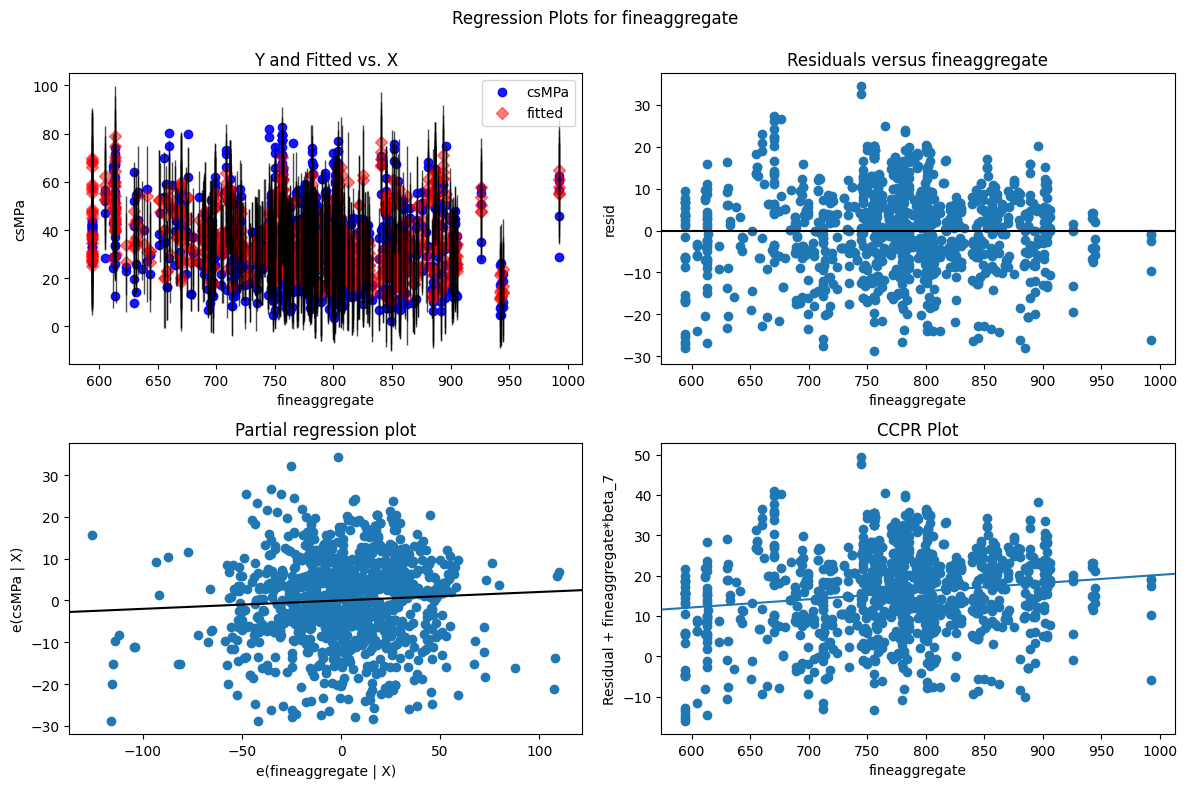

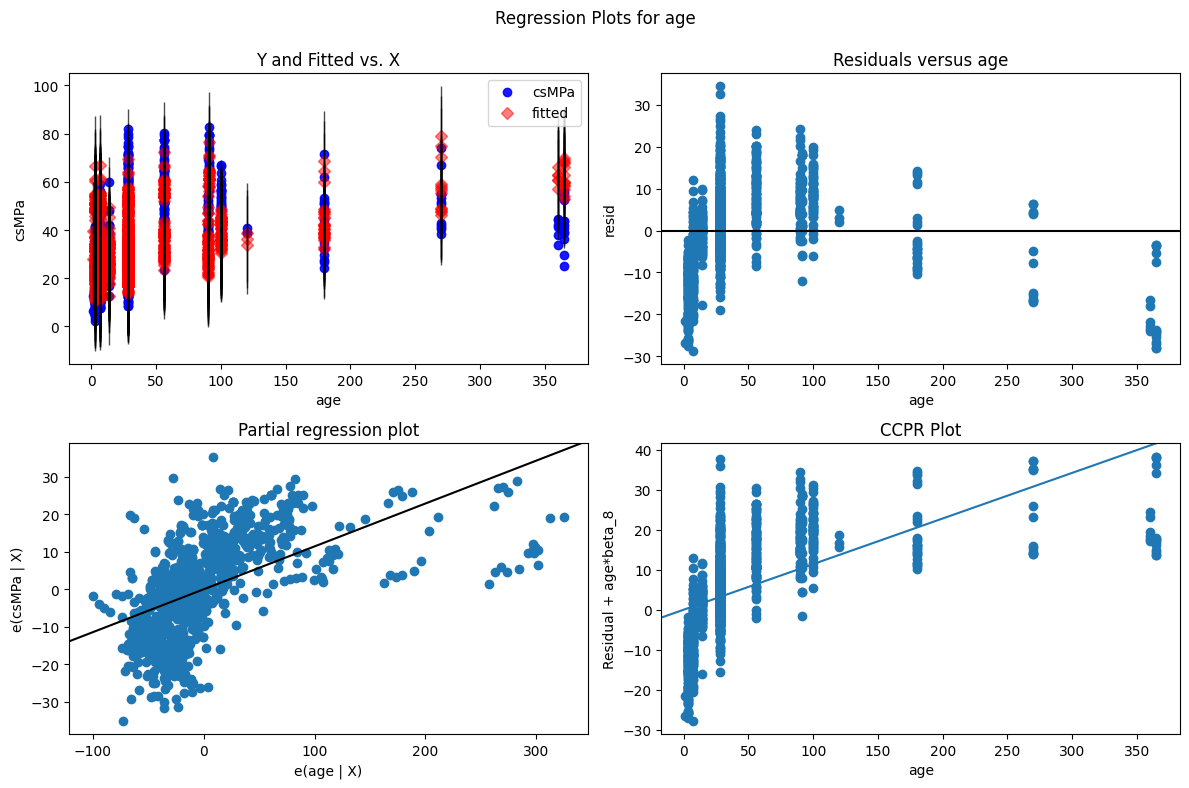

In [30]:
from statsmodels.formula.api import ols

#fit multiple linear regression model
model = ols('csMPa ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age', data=concrete_data).fit()

#create residual vs. predictor plot for 'assists'
for i in X.columns:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(model, i, fig=fig)
    fig.show()